# Установка пакетов

In [ ]:
!pip install boto3
!pip install s3fs

# Импорт пакетов

In [ ]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import io
import datetime as dt
import numpy as np
import seaborn as sns
import warnings

warnings.simplefilter('ignore')
s3 = boto3.resource('s3',
                endpoint_url='https://storage.yandexcloud.net',
                region_name = 'ru-central1',
                aws_access_key_id = '',
                aws_secret_access_key = ''
                )
data_bucket = s3.Bucket('mlops-data')

## Проверка подключения

In [ ]:
count = sum(1 for _ in data_bucket.objects.all())
print(f'{count} файлов')

40 файлов


# Проверка корректности данных

## 1. Проверка полноты данных

In [ ]:
def check_data(data, cols, n_bytes = 10000):
    txt = data.get().get('Body').read(n_bytes).decode()
    header = txt.split('\n')[0]
    body = '\n'.join(txt.split('\n')[1:])
    header = [i.strip() for i in header.replace('#', '').split('|')]
    df= pd.read_csv(io.StringIO(body),sep=',', engine = 'python', names=header)
    columns = df.columns.tolist()
    for new_c in columns:
        if new_c not in cols.keys():
            print(f'Обнаружен новый столбец {new_c}')
            cols[new_c] = dict()
            cols[new_c].update({'dtype': [df[new_c].dtype],
                                'NA': [df[new_c].isna().sum()],
                                'nrows': [df.shape[0]]
                                })
        else:
            cols[new_c]['dtype'].append(df[new_c].dtype)
            cols[new_c]['NA'].append(df[new_c].isna().sum())
            cols[new_c]['nrows'].append(df.shape[0])
    for old_c in cols.keys():
        if old_c not in columns:
            print(f'{old_c} нет в списке столбцов!')
    return cols # Dict[colname: [List of dtypes]]

def read_csv(s3obj, n_bytes = 10000):
    txt = data.get().get('Body').read(n_bytes).decode()
    header = txt.split('\n')[0]
    body = '\n'.join(txt.split('\n')[1:])
    header = [i.strip() for i in header.replace('#', '').split('|')]
    df= pd.read_csv(io.StringIO(body),sep=',', engine = 'python', names=header)
    return df

In [ ]:
cols = dict()
for data in data_bucket.objects.all():
    print(f'========= {data.key} ========')
    cols = check_data(data, cols)

In [ ]:
summary = pd.DataFrame(columns=['dtype', 'NA', 'nrows'])
for key, value in cols.items():
    row = pd.Series(value)
    row['NA'] = sum(row['NA'])
    row['nrows'] = sum(row['nrows'])
    row['dtype'] = set(row['dtype'])
    summary.loc[key] = row
summary['%NA'] = summary['NA'] / summary['nrows']
summary

,dtype,NA,nrows,%NA
tranaction_id,{int64},0,6607,0.0
tx_datetime,{object},9,6607,0.001362
customer_id,"{int64, float64}",25,6607,0.003784
terminal_id,"{int64, float64}",26,6607,0.003935
tx_amount,{float64},27,6607,0.004087
tx_time_seconds,"{int64, float64}",33,6607,0.004995
tx_time_days,"{int64, float64}",39,6607,0.005903
tx_fraud,"{int64, float64}",39,6607,0.005903
tx_fraud_scenario,{float64},40,6607,0.006054


Некоторые столбцы представлены несколькими типами данных. Количество пропусков не превышает . процентов.

## 2. Поиск выбросов

Файлов немного можно посмотреть распреление данных "глазами". Если бы их было больше можно бы было делать рандомный сэмпл из файлов. Проанализоровать распределение данных в этом сэмпле и распространить на всю выборку.

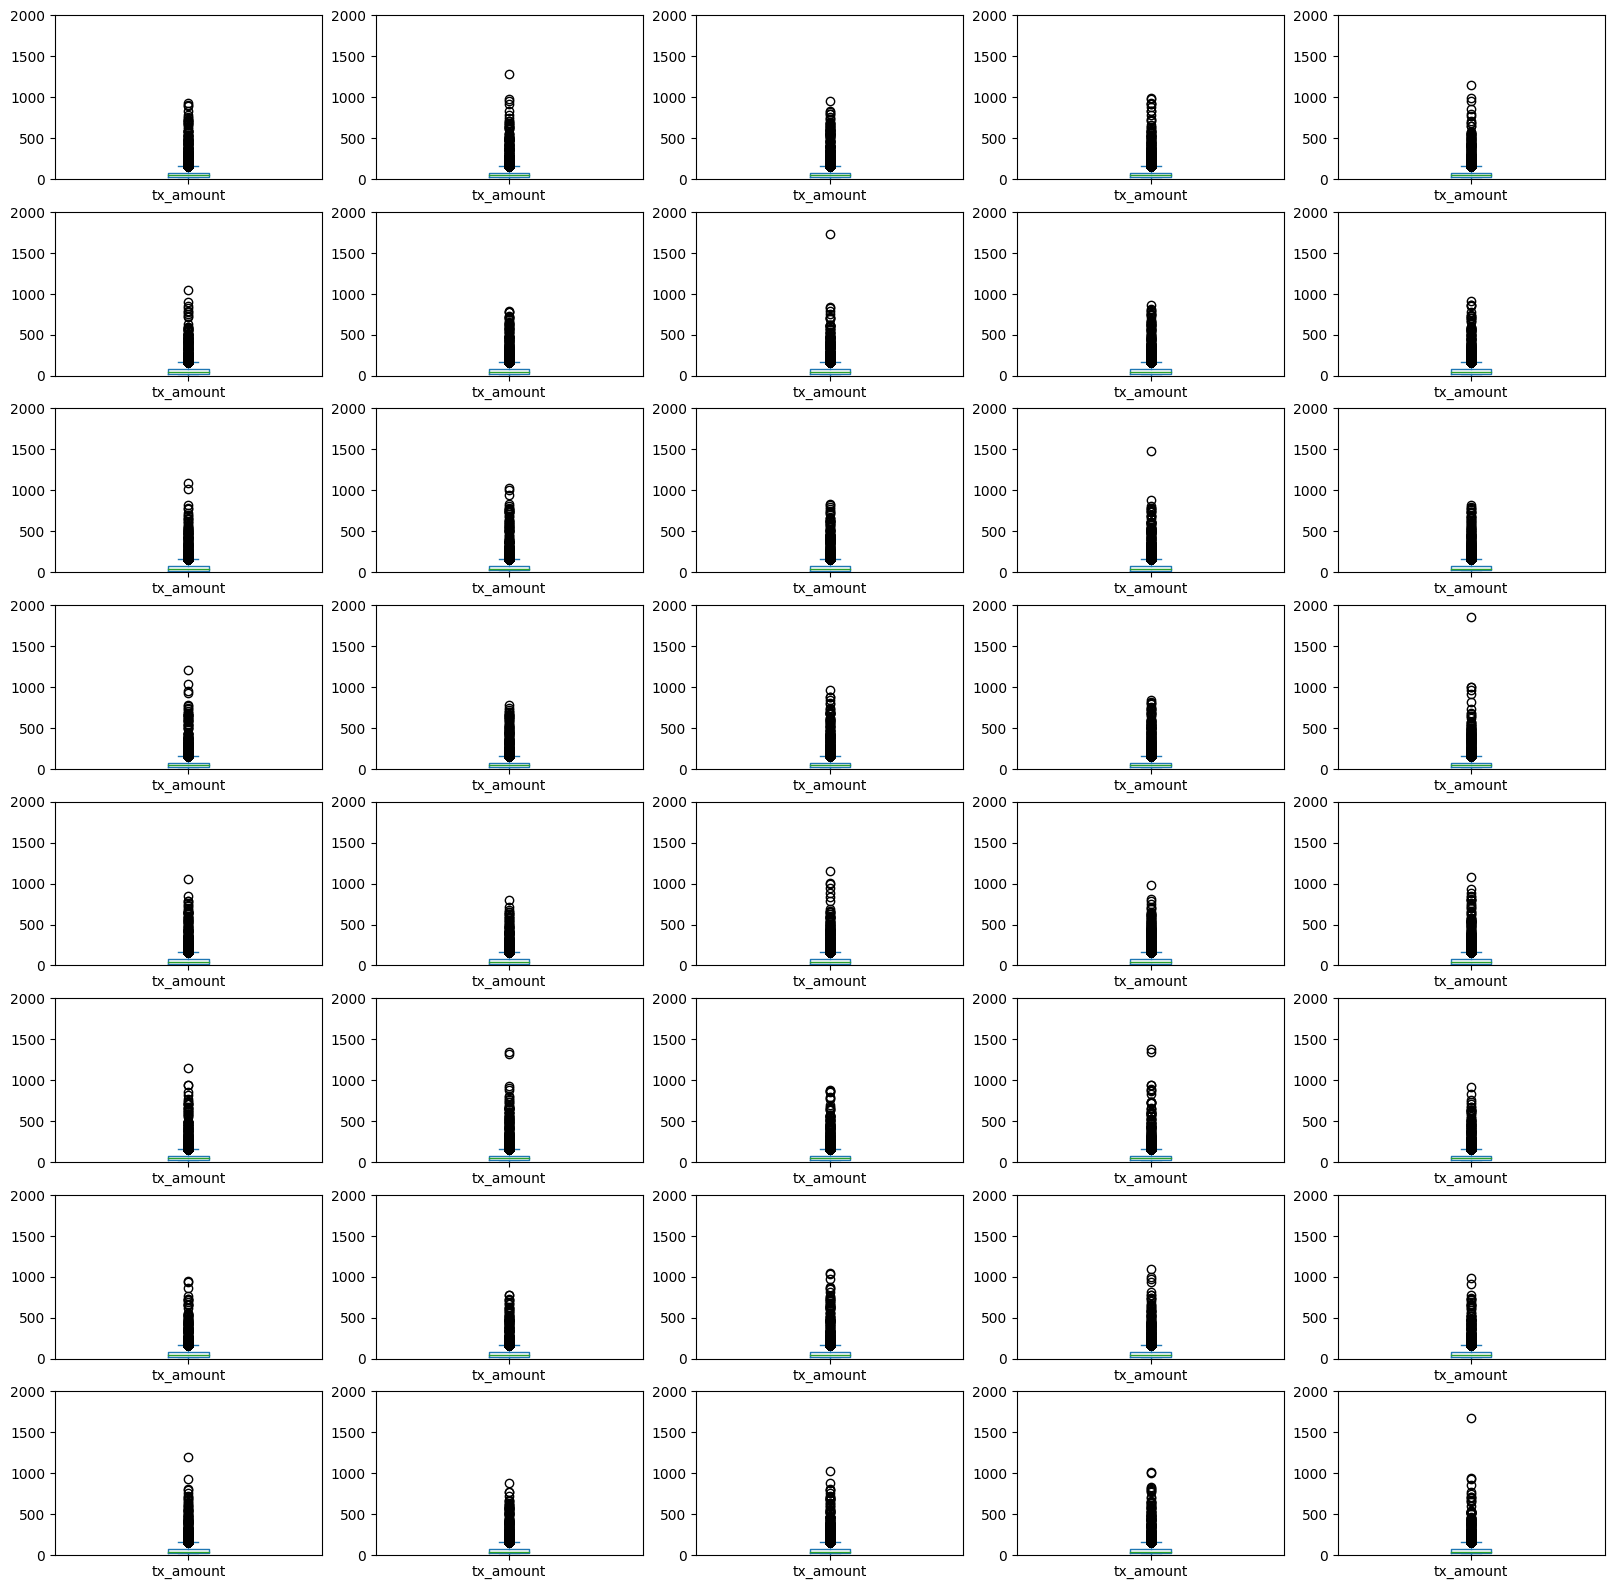

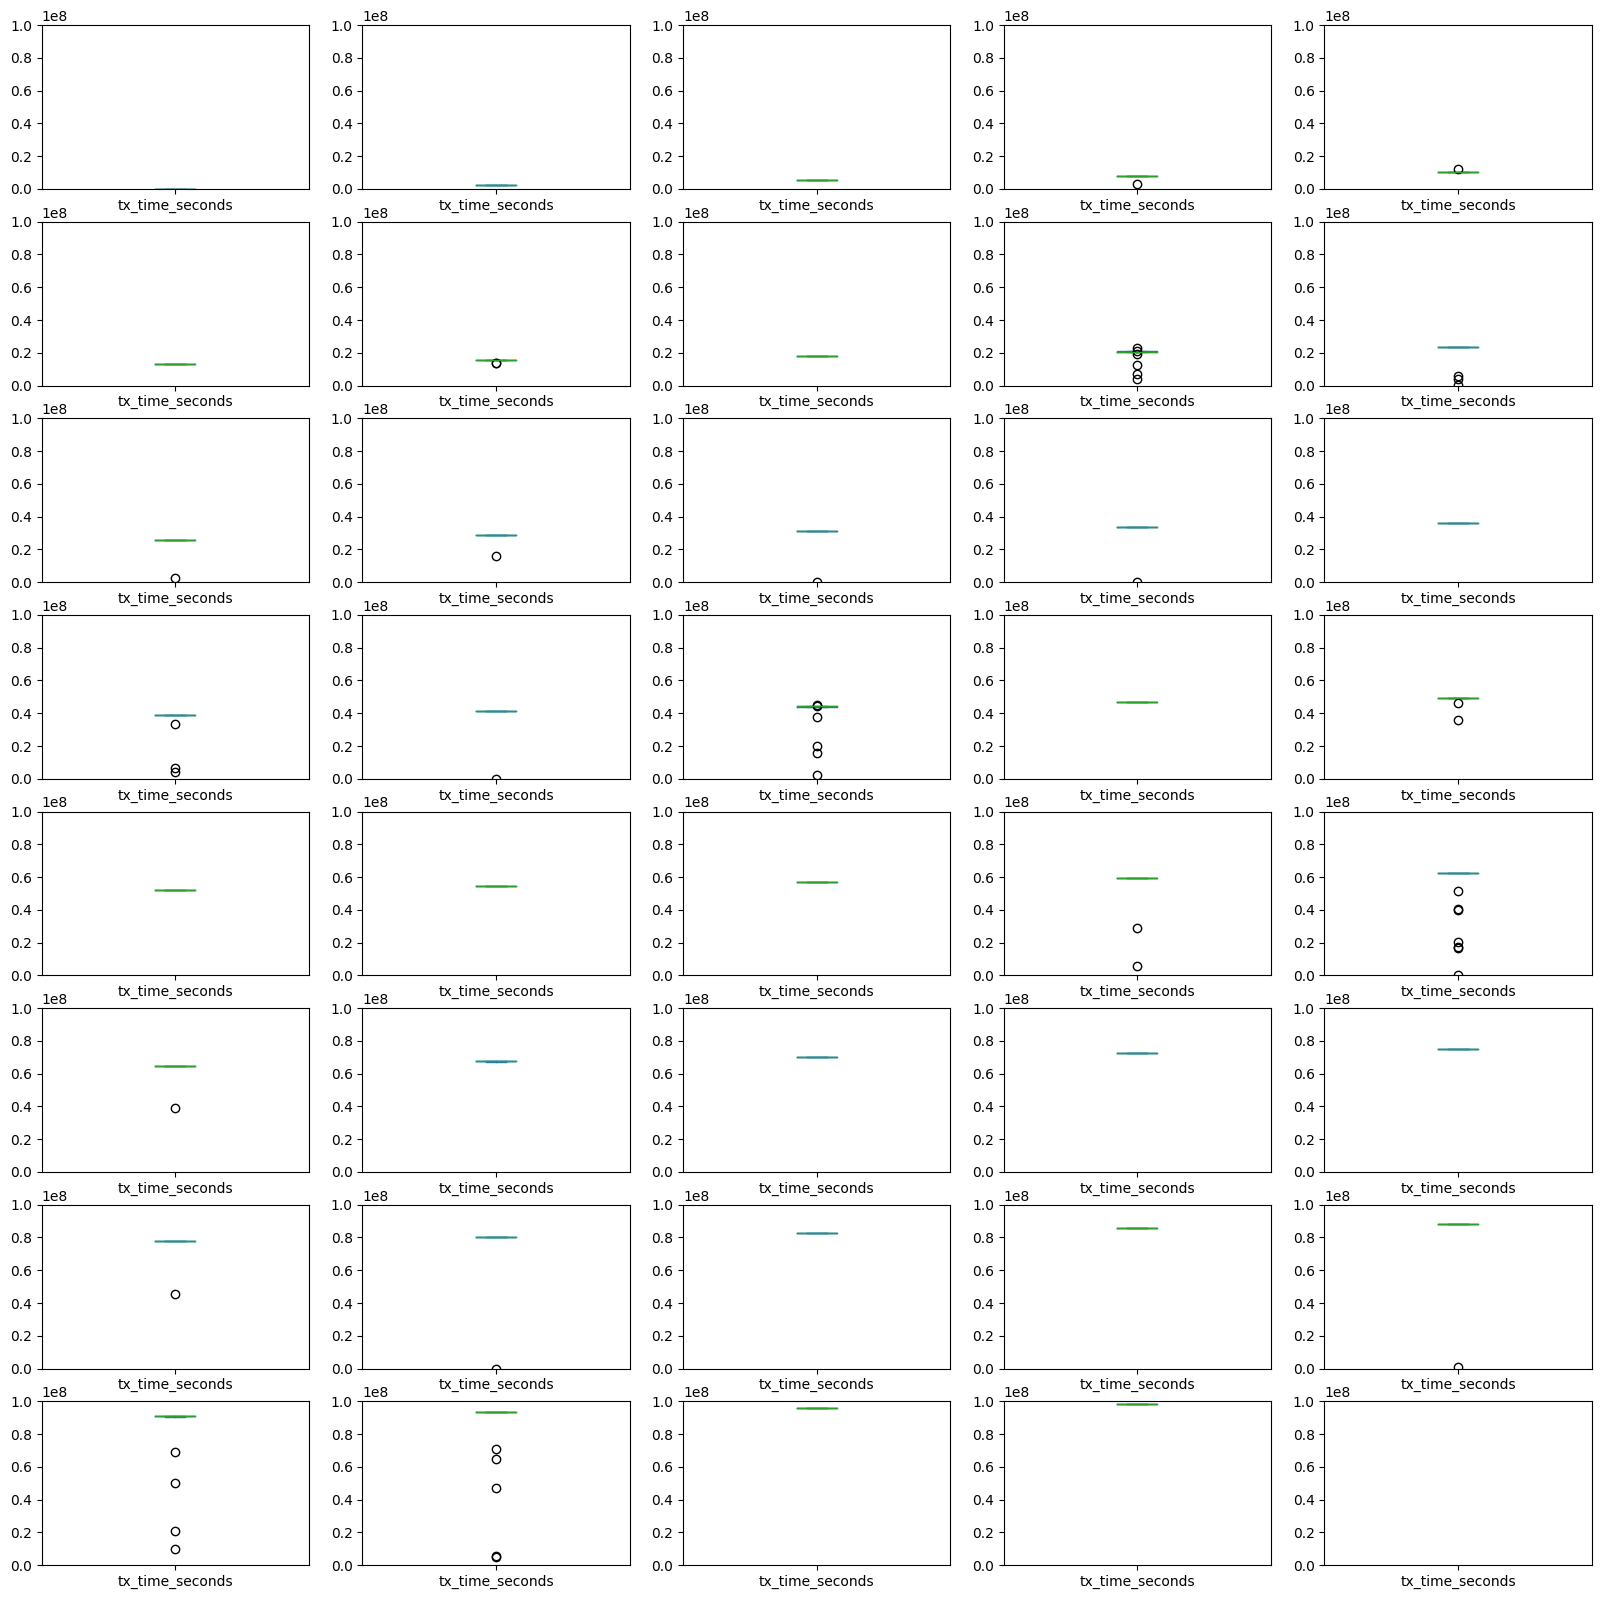

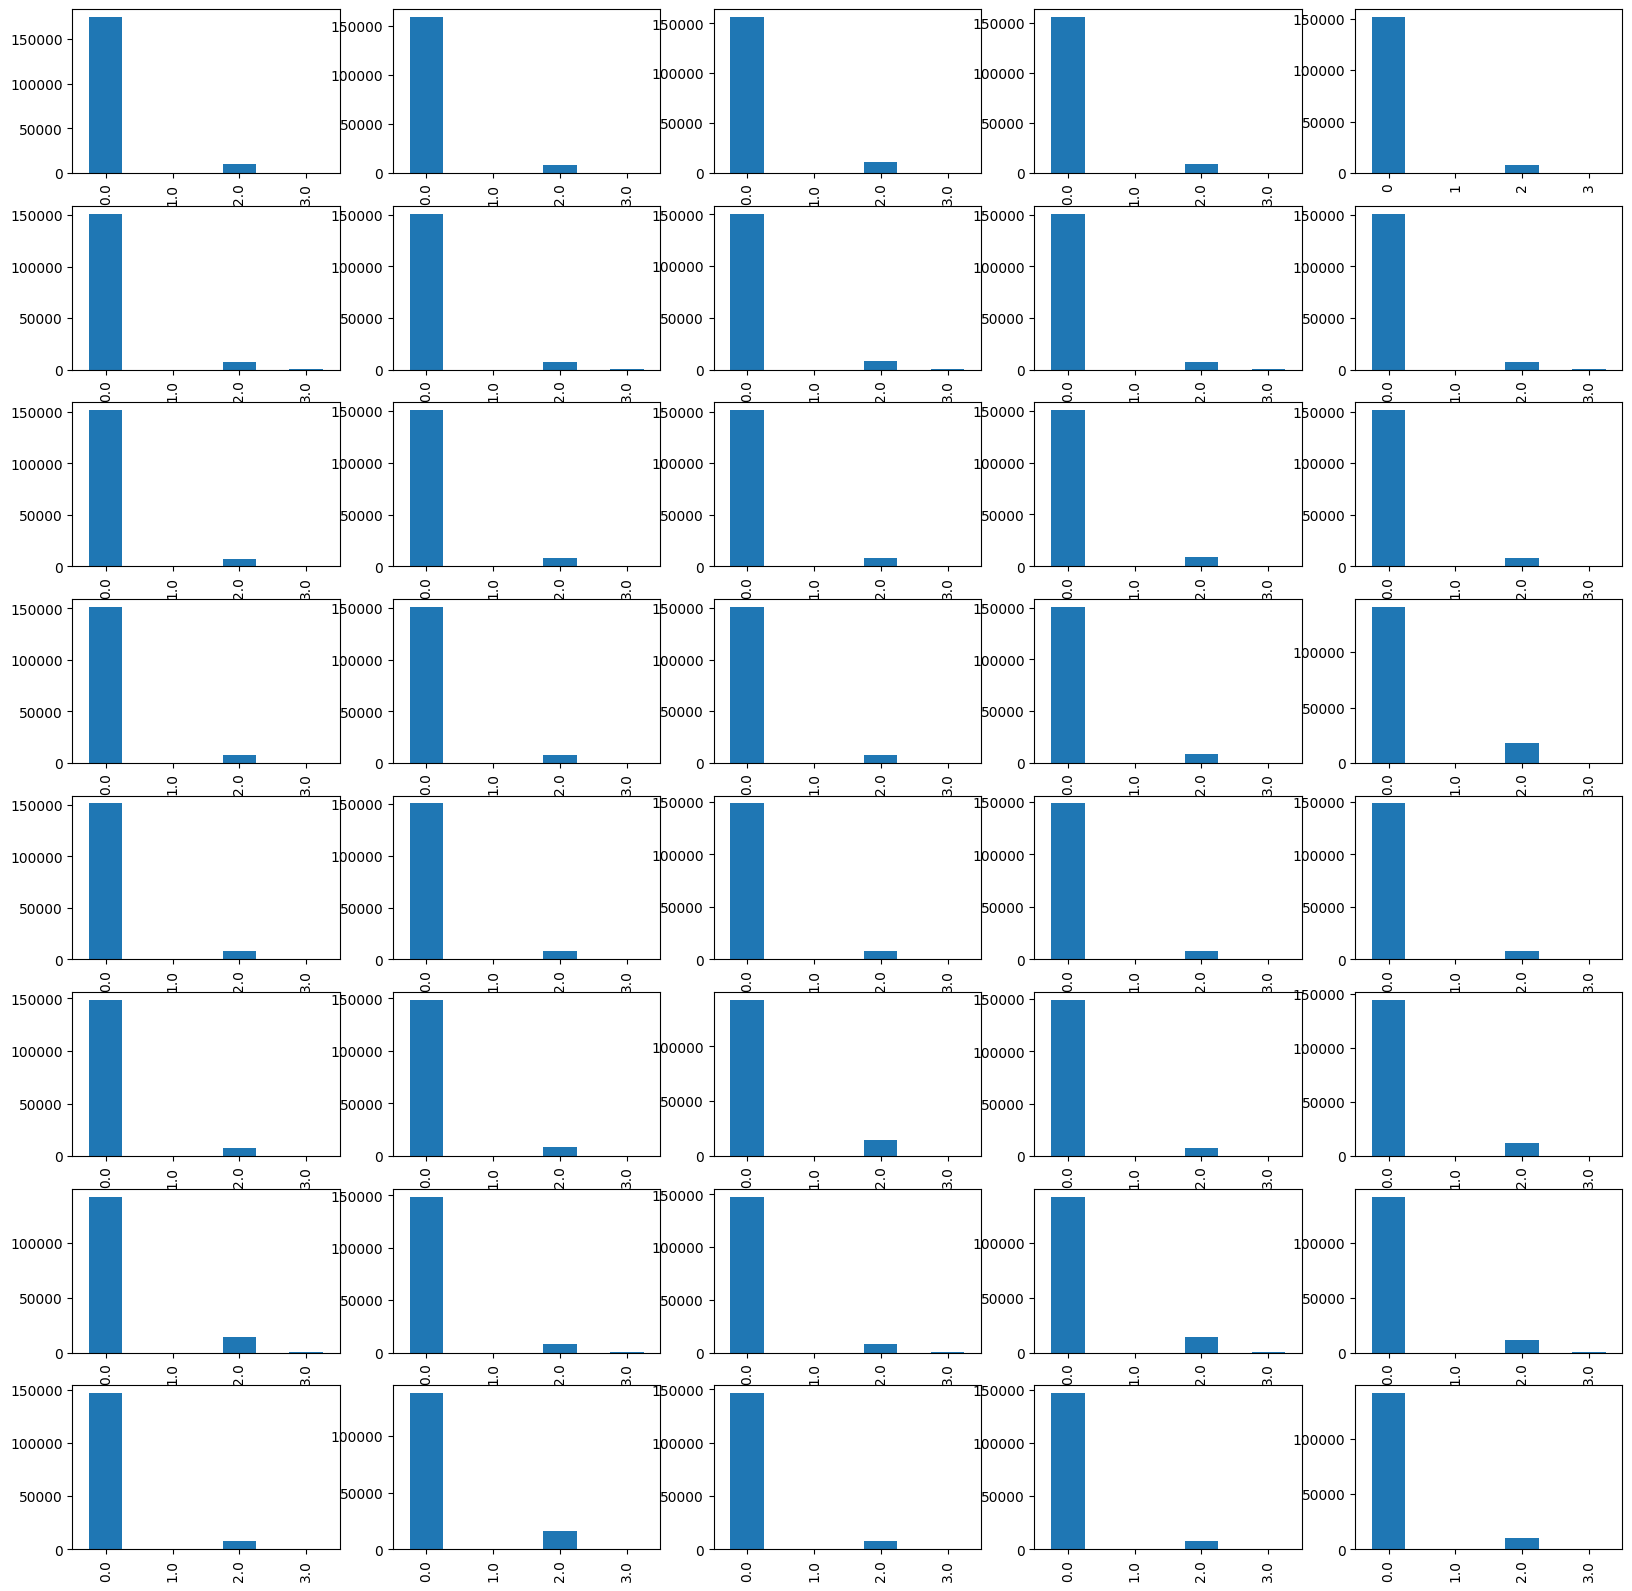

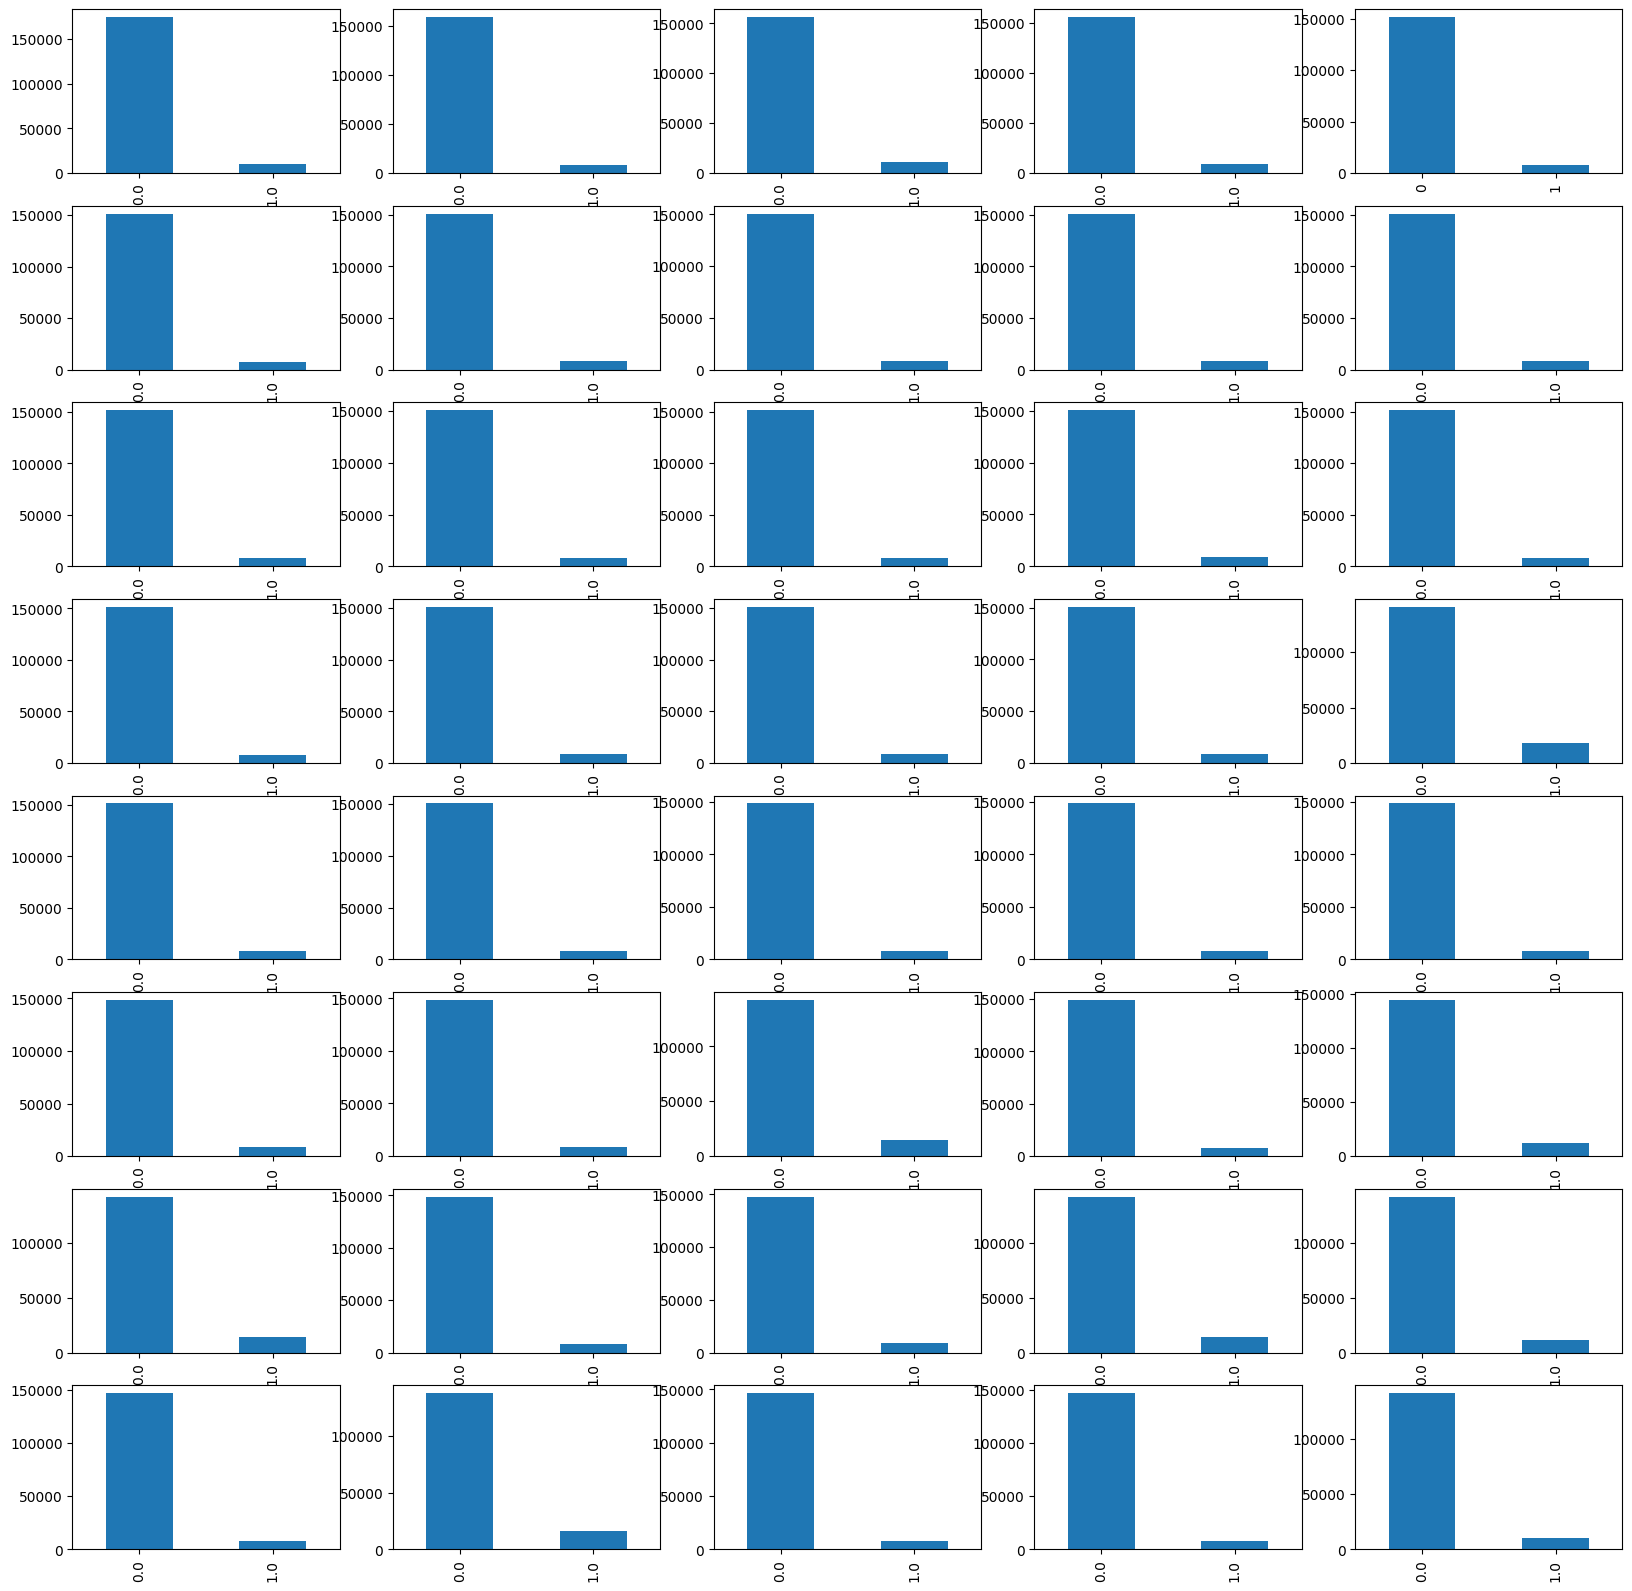

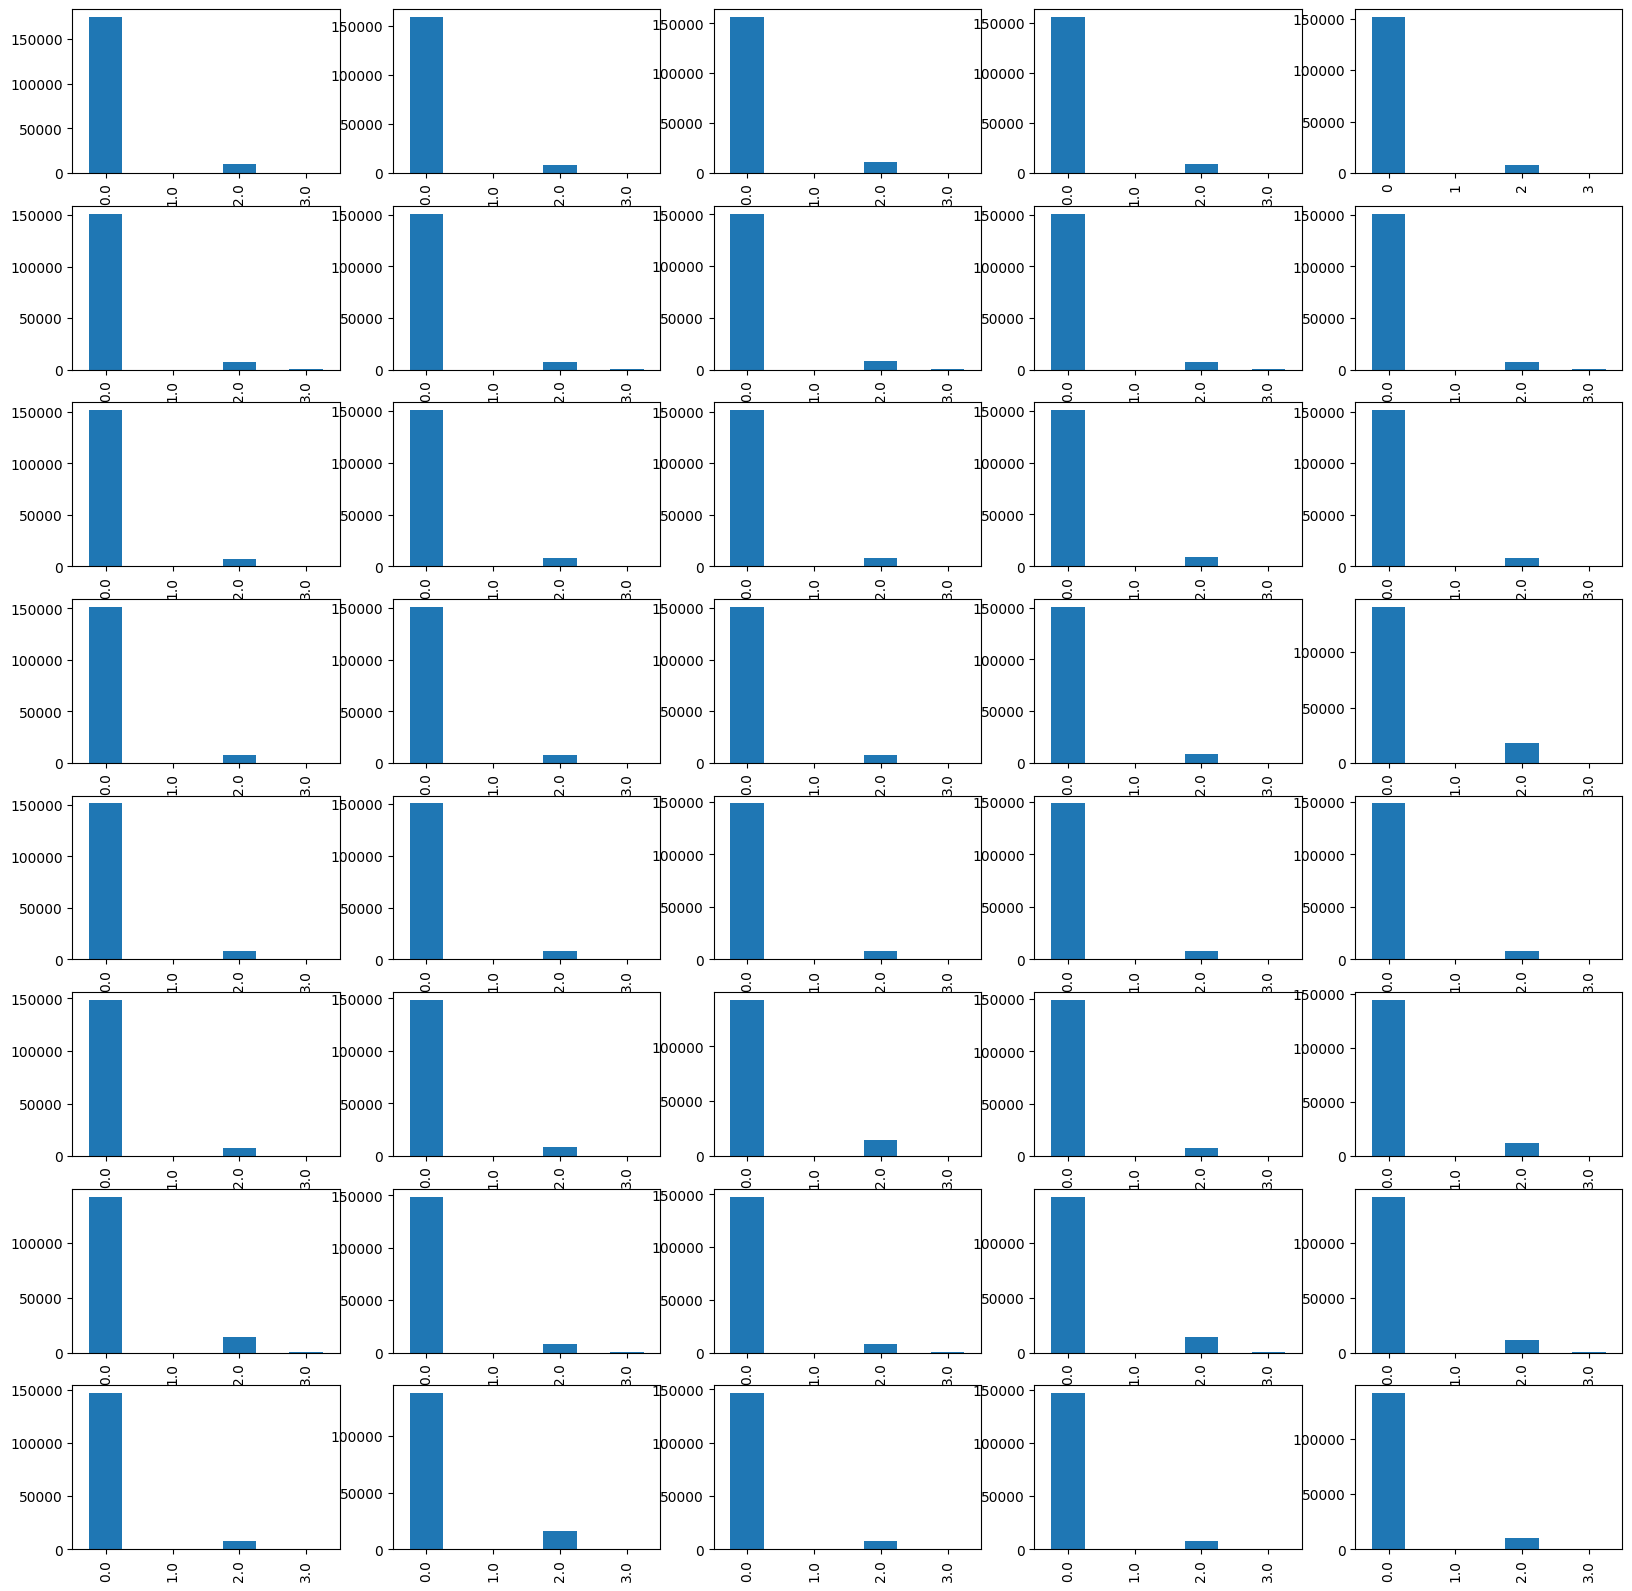

In [ ]:
tx_amount, tx_amount_ax = plt.subplots(nrows=8, ncols=5, figsize=(20,20))
tx_time_seconds, tx_time_seconds_ax = plt.subplots(nrows=8, ncols=5, figsize=(20,20))
tx_time_days, tx_time_days_ax = plt.subplots(nrows=8, ncols=5, figsize=(20,20))
tx_fraud, tx_fraud_ax = plt.subplots(nrows=8, ncols=5, figsize=(20,20))
tx_fraud_scenario, x_fraud_scenario_ax = plt.subplots(nrows=8, ncols=5, figsize=(20,20))

[[i.set_ylim(0, 2000) for i in row] for row in tx_amount_ax]
[[i.set_ylim(0, 10**8) for i in row] for row in tx_time_seconds_ax]

n_row, n_col = 0, 0
for data in data_bucket.objects.all():
    # Тут надо прочитать полностью
    df = read_csv(data, n_bytes = 10000000)
    df['tx_amount'].plot.box(ax=tx_amount_ax[n_row, n_col])
    df['tx_time_seconds'].plot.box(ax=tx_time_seconds_ax[n_row, n_col])
    df['tx_fraud_scenario'].value_counts().sort_index().plot.bar(ax=tx_time_days_ax[n_row, n_col])
    df['tx_fraud'].value_counts().sort_index().plot.bar(ax=tx_fraud_ax[n_row, n_col])
    df['tx_fraud_scenario'].value_counts().sort_index().plot.bar(ax=x_fraud_scenario_ax[n_row, n_col])
    n_row = n_row if n_col + 1 < 5 else n_row + 1
    n_col = n_col + 1 if n_col < 4 else 0

## Проверка дат

In [ ]:
import numpy as np

def check_datetime_format(dt):
    year, month, day, hour, minute, sec = [], [], [], [], [], []
    bad = []
    for i in dt:
        try:
            date, time = i.split()
            Y = int(date.split('-')[0])
            m = int(date.split('-')[1])
            d = int(date.split('-')[2])
            H = int(time.split(':')[0])
            M = int(time.split(':')[1])
            S = int(time.split(':')[2])

            if Y not in year:
                year.append(int(Y))
            if m not in month:
                month.append(int(m))
            if d not in day:
                day.append(int(d))
            if H not in hour:
                hour.append(int(H))
            if M not in minute:
                minute.append(int(M))
            if S not in sec:
                sec.append(int(S))
        except:
            bad.append(i)

    print('bad format:', bad)


    print(f'Unique years: {sorted(year)}')
    print('Min', np.min(year), 'Max:', np.max(year), end='\n')
    print(f'Unique months: {sorted(month)}')
    print('Min', np.min(month), 'Max:', np.max(month),  end='\n')
    print(f'Unique days: {sorted(day)}')
    print('Min', np.min(day), 'Max:', np.max(day), end='\n')
    print(f'Unique hours: {sorted(hour)}')
    print('Min', np.min(hour), 'Max:', np.max(hour), end='\n')
    print(f'Unique minutes: {sorted(minute)}')
    print('Min', np.min(minute), 'Max:', np.max(minute), end='\n')
    print(f'Unique seconds: {sorted(sec)}')
    print('Min', np.min(sec), 'Max:', np.max(sec), end='\n')

cols = []
for data in data_bucket.objects.all():
    print(f'========= {data.key} ========')
    check_datetime_format(read_csv(data, n_bytes = 10000000)['tx_datetime'])

========= fraud-data/2019-08-22.txt ========
bad format: ['2019-08-']
Unique years: [2019]
Min 2019 Max: 2019
Unique months: [8]
Min 8 Max: 8
Unique days: [22]
Min 22 Max: 22
Unique hours: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Min 0 Max: 23
Unique minutes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Min 0 Max: 59
Unique seconds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Min 0 Max: 59
========= fraud-data/2019-09-21.txt ========
bad format: []
Unique years: [2019]
Min 2019 Max: 2019
Unique months: [9]
Min 9 Max: 9
Unique days: [21]
Min 21 Max: 21
Unique hours: [0, 1, 2,

Обнаружен аномальный 24 час в некоторых файлах, заменяю его на следующий день.

2022-03-03 24:00:00 -> 2022-03-04 00:00:00

In [ ]:
def fix_date(d, verbose=False):
    dates = []
    e = 0
    f = 0
    for i in d:
        try:
            date, time = i.split()
            Y = date.split('-')[0]
            m = date.split('-')[1]
            d = date.split('-')[2]
            H = time.split(':')[0]
            M = time.split(':')[1]
            S = time.split(':')[2]
            if H == '24':
                H = '23'
                f += 1
            dates.append(np.datetime64(f'{Y}-{m}-{d} {H}:{M}:{S}') + np.timedelta64(1, 'h'))
        except:
            dates.append(np.datetime64('NaT'))
            e += 1
    if verbose:
        print(f'Обнаружено {e + f} ошибок в дате, исправлено {f}')
    return dates

fix_date(['2023-03-03 14:23:41', '2023-03-03 24:23:41', '23'], True)

Обнаружено 2 ошибок в дате, исправлено 1


[numpy.datetime64('2023-03-03T15:23:41'),
 numpy.datetime64('2023-03-04T00:23:41'),
 numpy.datetime64('NaT')]

## Проверка зависимости количественных данных `tx_amount` и `tx_time_seconds` от времени `tx_datetime`.

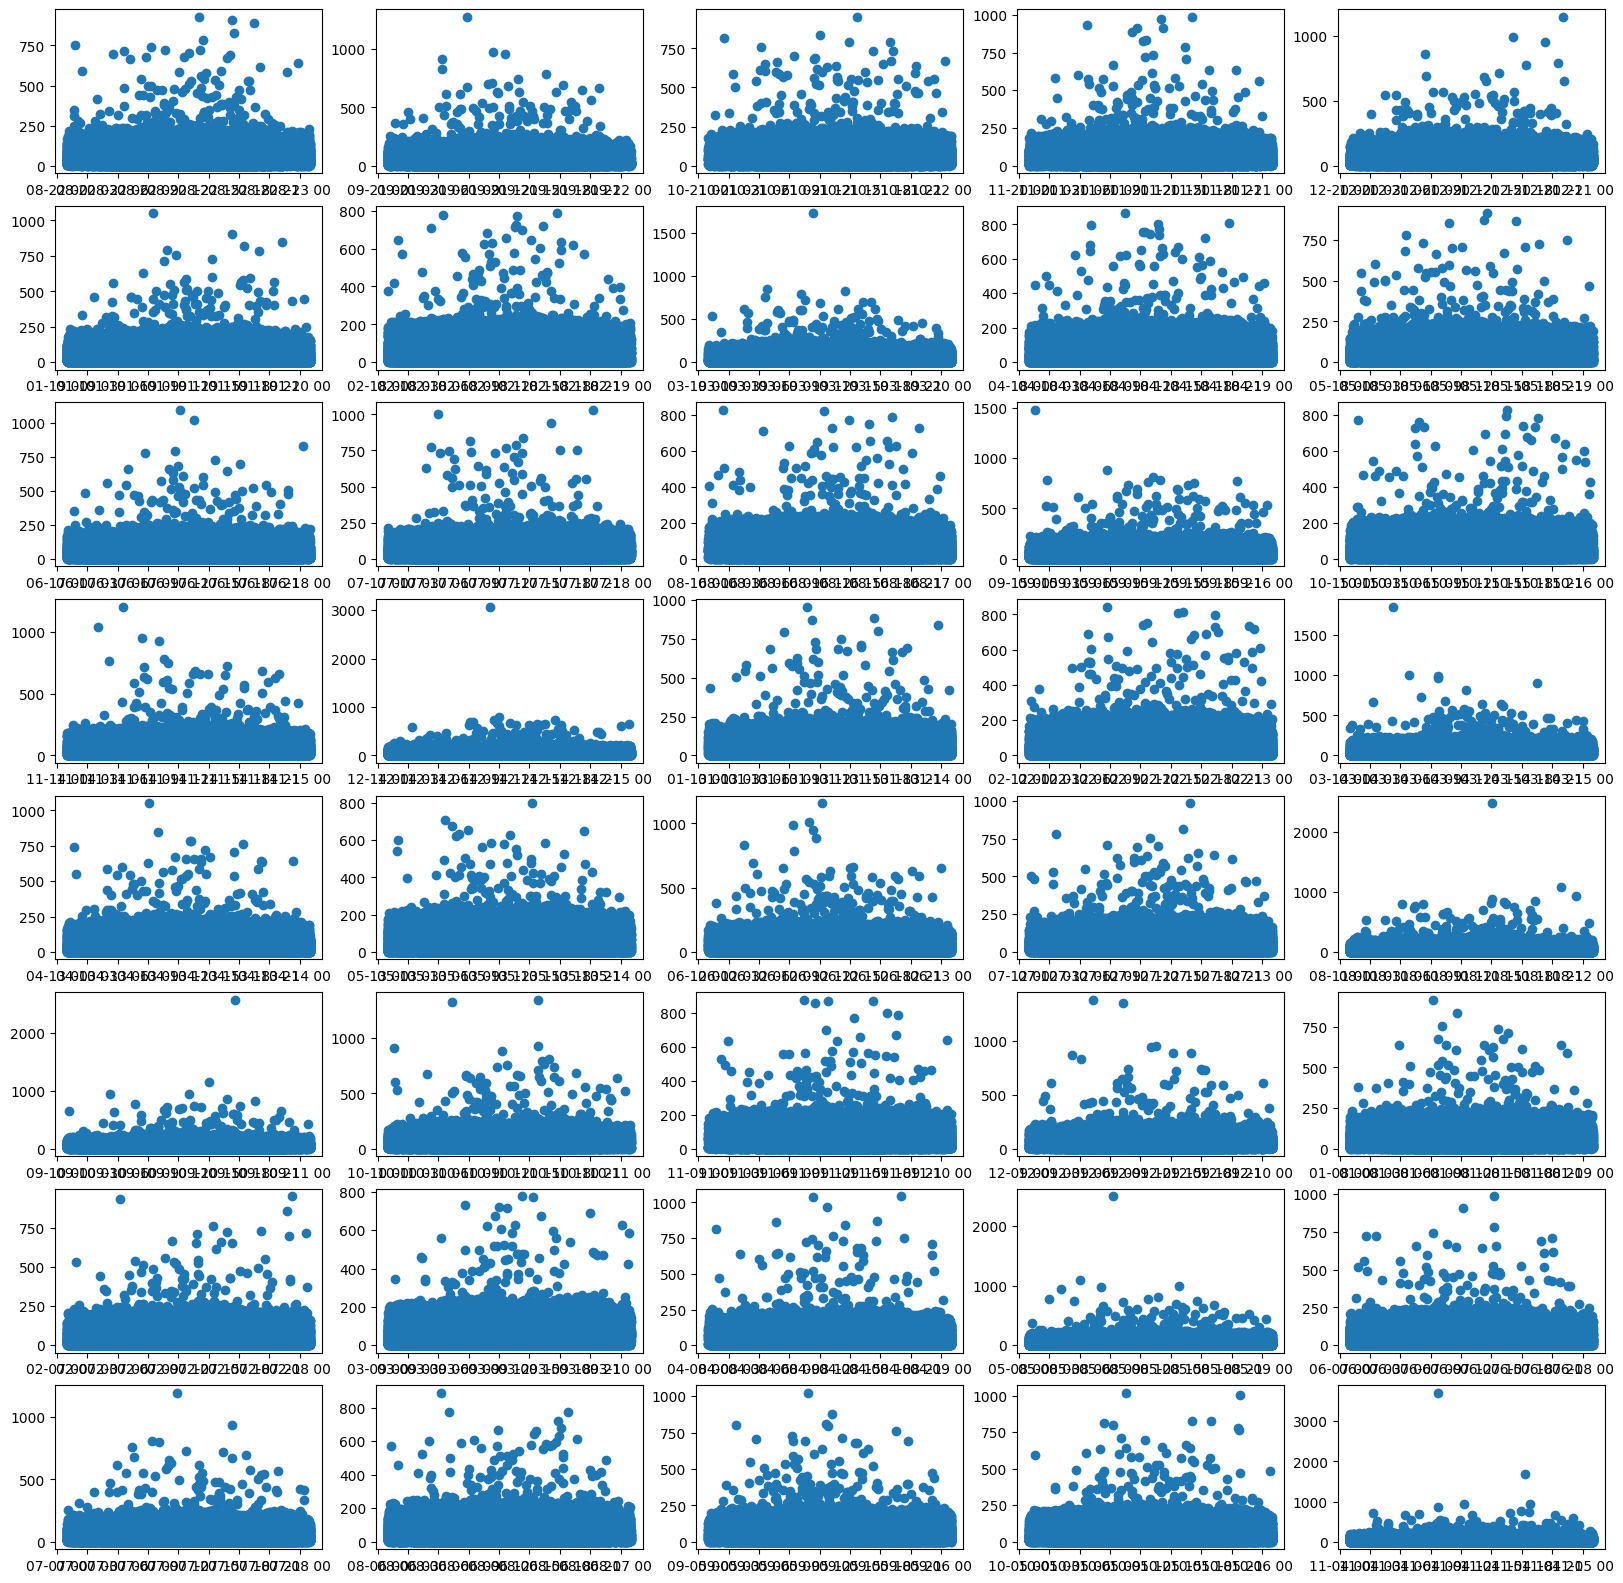

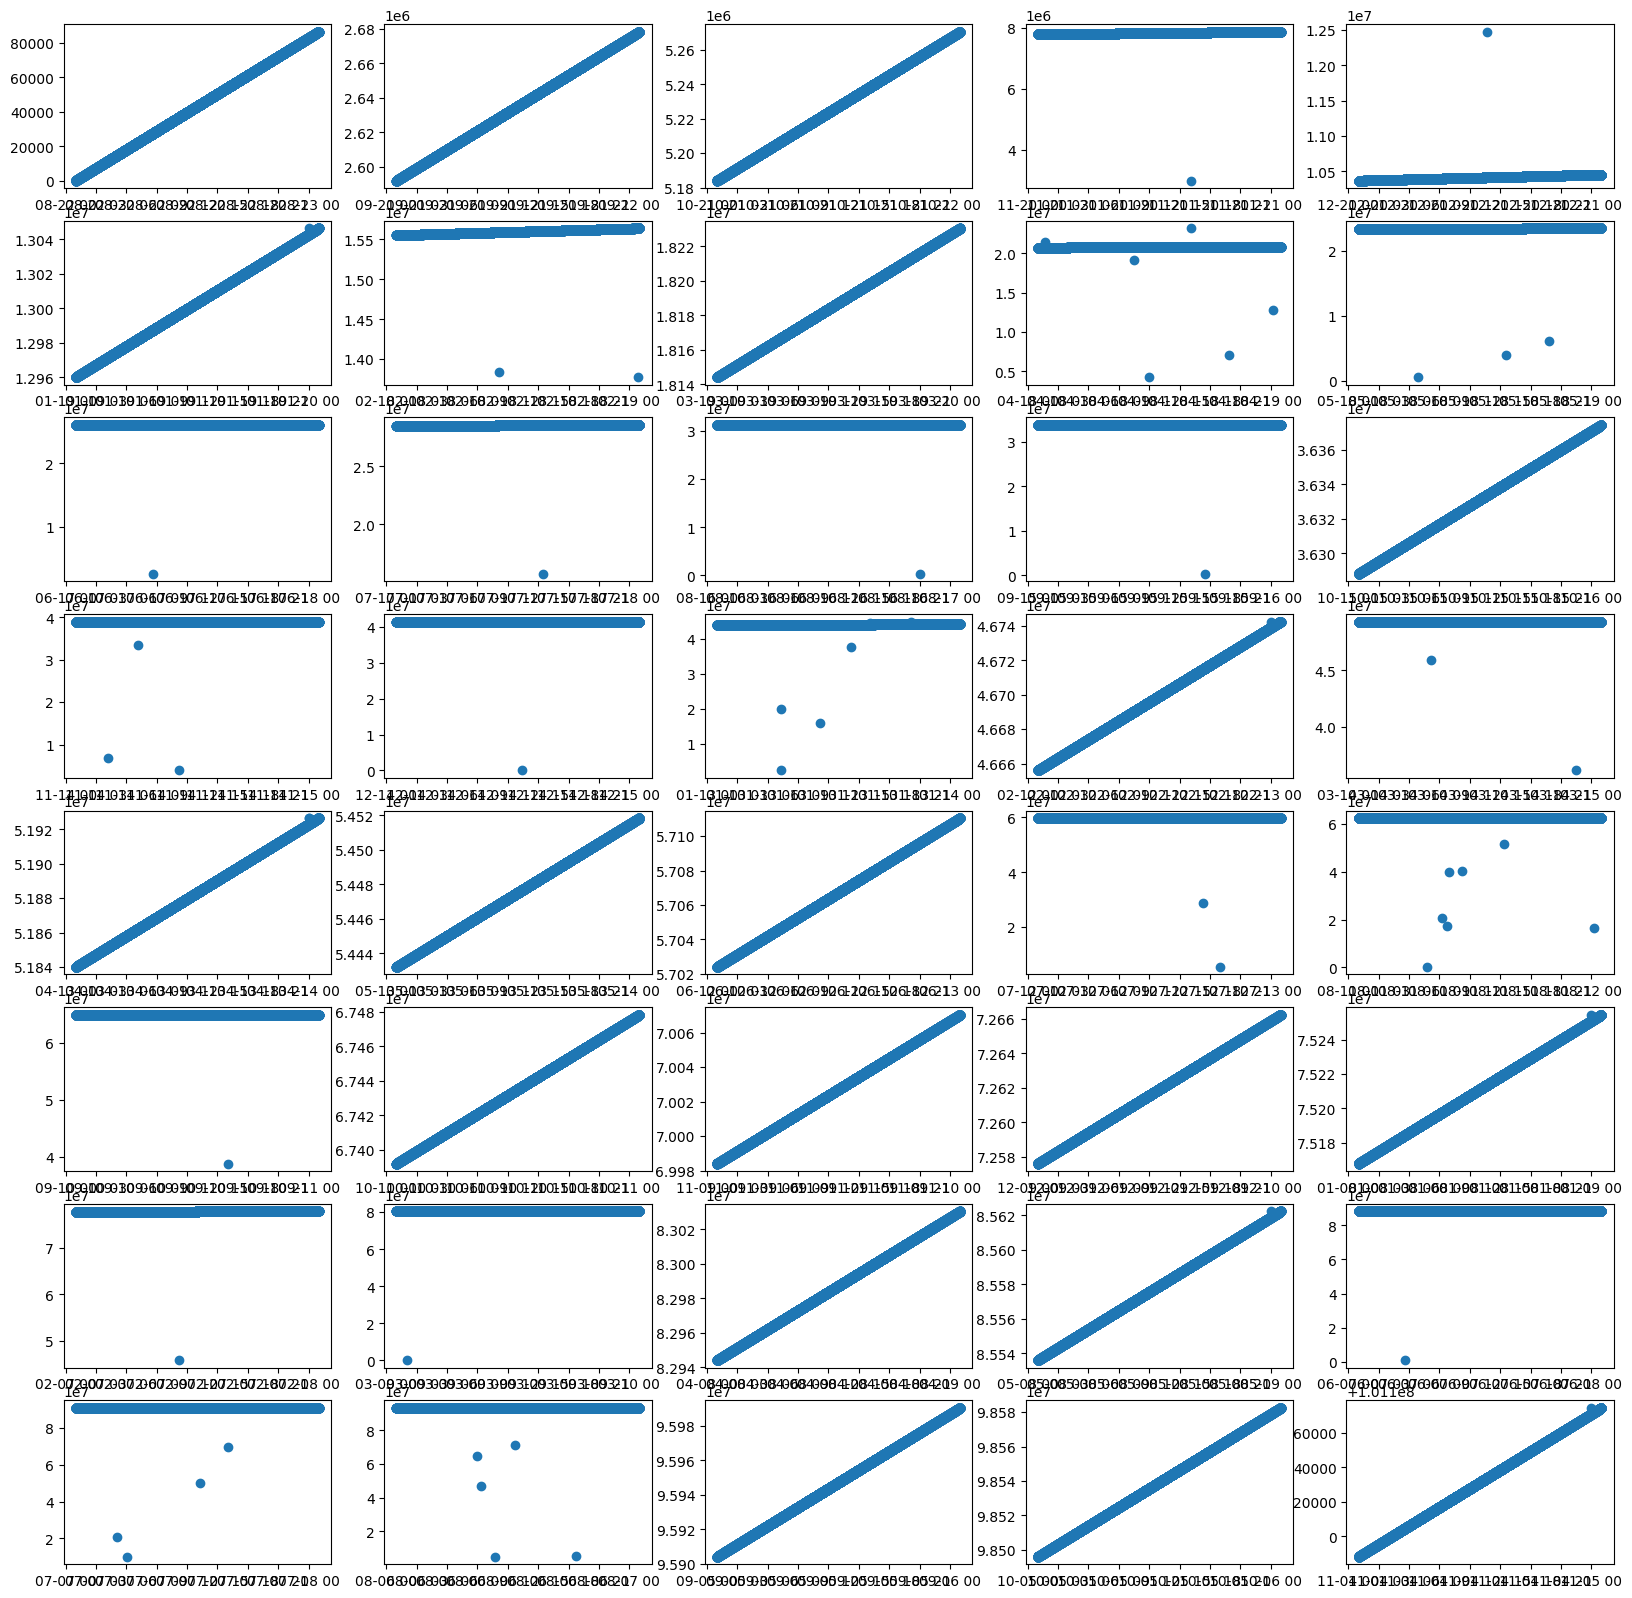

In [ ]:
tx_amount, tx_amount_ax = plt.subplots(nrows=8, ncols=5, figsize=(20,20))
tx_time_seconds, tx_time_seconds_ax = plt.subplots(nrows=8, ncols=5, figsize=(20,20))
n_row, n_col = 0, 0
for data in data_bucket.objects.all():
    # Тут надо прочитать полностью
    df = read_csv(data, n_bytes = 10000000)
    df = df[['tx_datetime', 'tx_amount', 'tx_time_seconds']]
    df.sort_values('tx_datetime', inplace=True)
    tx_amount_ax[n_row, n_col].scatter(fix_date(df['tx_datetime']), df['tx_amount'])
    tx_time_seconds_ax[n_row, n_col].scatter(fix_date(df['tx_datetime']), df['tx_time_seconds'])
    n_row = n_row if n_col + 1 < 5 else n_row + 1
    n_col = n_col + 1 if n_col < 4 else 0

На графиках `tx_amount` видны точки, которые заметно выделяются относительно большинства. Взаимосвязь `tx_time_seconds` и `tx_datetime` носит линейный характер. Скорее всего это какой-то timestamp от определенной даты. Однако есть точки, которые значительно отклоняются от линейной зависимости.

Найдем 99 процентиль `tx_amount`. В дальнейшем будем его использовать для удаления выбросов.

In [ ]:
precentiles = pd.DataFrame()
for data in data_bucket.objects.all():
    # Тут надо прочитать полностью
    df = read_csv(data, n_bytes = 10000000)
    df = df[df['tx_amount'].notna() & df['tx_time_seconds'].notna()] # Удаляем пропуски
    df['tx_datetime'] = fix_date(df['tx_datetime']) # Фиксим некорректные даты
    df['date'] = df['tx_datetime'].dt.date
    df = df[['date','tx_amount',  'tx_time_seconds']]
    df = df.groupby('date', as_index=False).agg(tx_amount_lower=('tx_amount', lambda x: np.percentile(x, 5)),
                                                        tx_amount_median=('tx_amount', lambda x: np.percentile(x, 50)),
                                                        tx_amount_higher=('tx_amount', lambda x: np.percentile(x, 95)))
    df['file'] = data.key
    precentiles = pd.concat([precentiles, df])

In [ ]:
q_95_tx_amount = precentiles.groupby('date', as_index=False)['tx_amount_higher'].median()

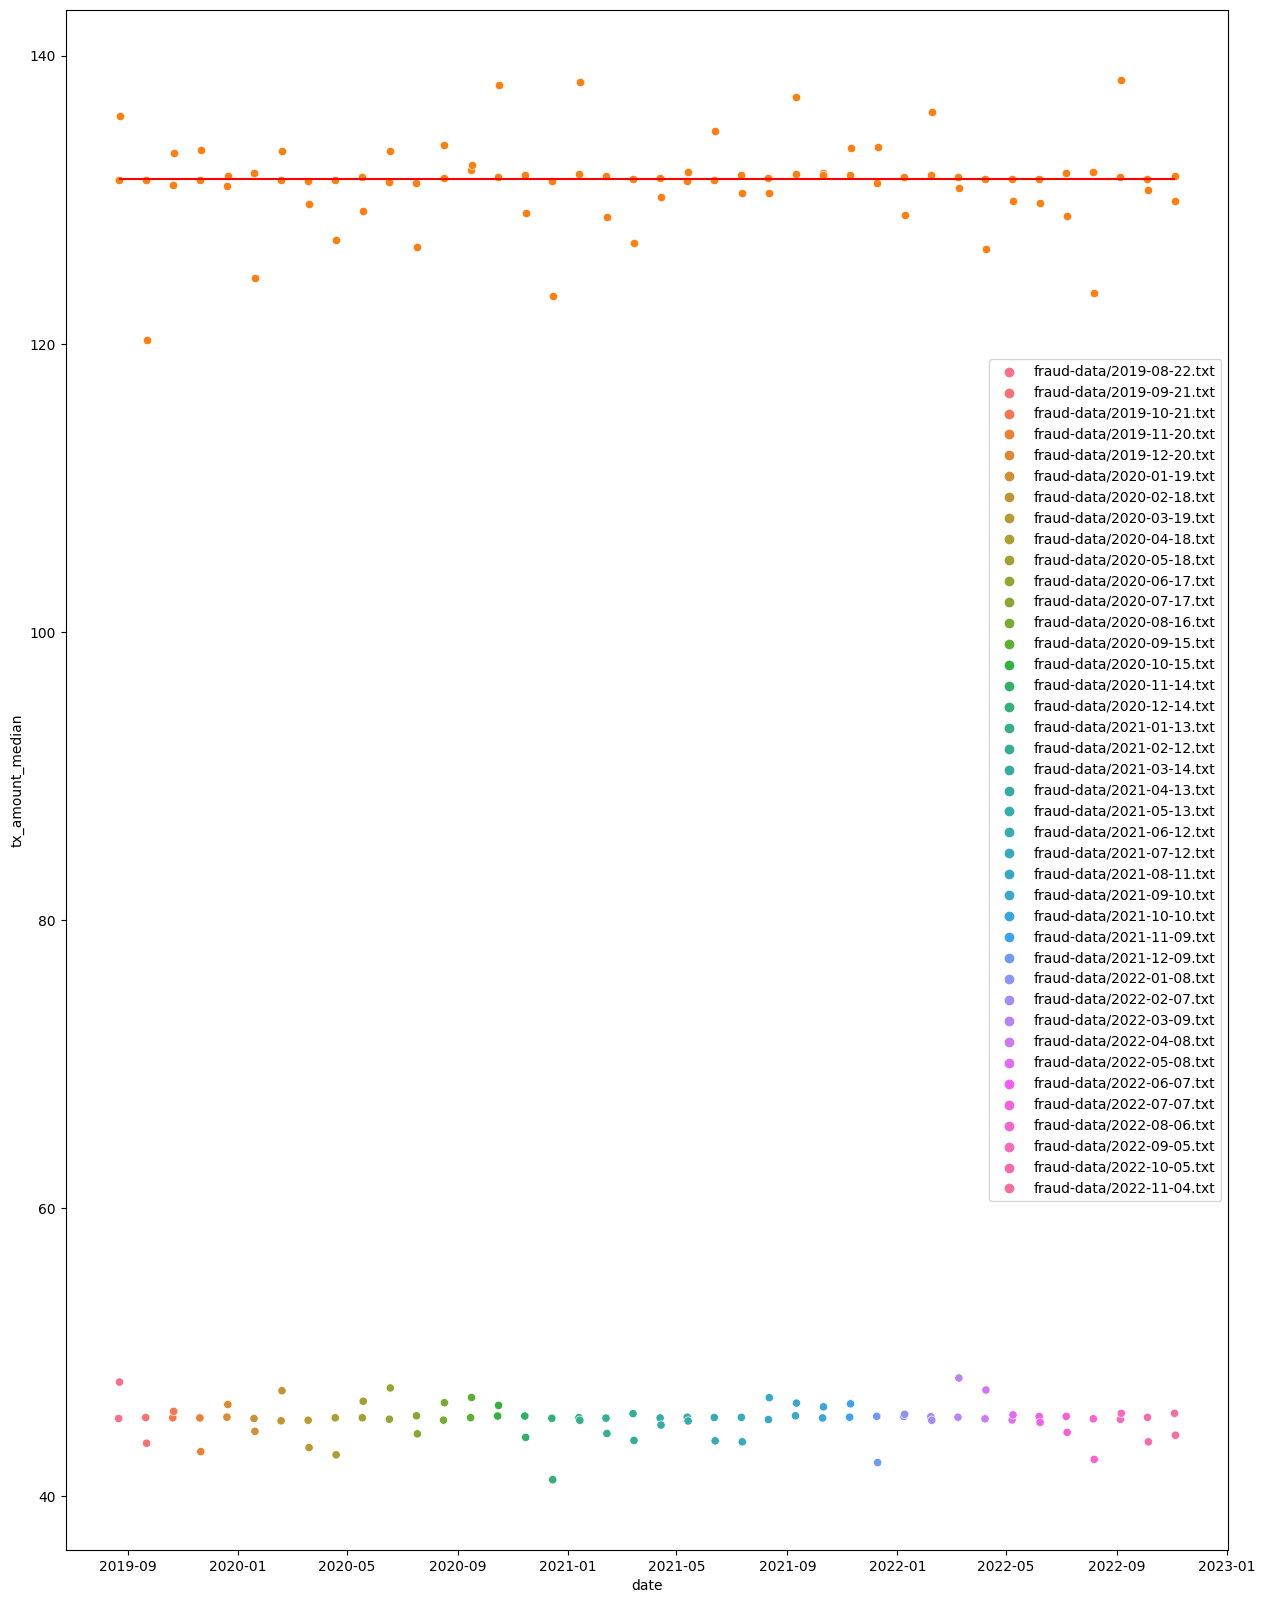

In [ ]:
fig, ax = plt.subplots(figsize=(15,20))

sns.scatterplot(precentiles, x='date', y='tx_amount_median', hue='file', ax=ax)
sns.scatterplot(q_95_tx_amount, x='date', y='tx_amount_higher', ax=ax)
ax.hlines(y=precentiles['tx_amount_higher'].median(), xmin=precentiles['date'].min(), xmax=precentiles['date'].max(), colors='red')

In [ ]:
tx_amount_95 = precentiles['tx_amount_higher'].median()
print(f'95 процениль tx_amount: {tx_amount_95:.2f}')

95 процениль tx_amount: 131.45


Найдем отклонения от линейной связи `tx_time_seconds` и `tx_datetime` с помощью линейной регрессии. Будем убирать остатки, которые больше 4 стандартных отклонений.

In [ ]:
n = 1
for data in data_bucket.objects.all():
    if n == 3:
        break
    n += 1

In [ ]:
df = read_csv(data, n_bytes = 10000000)
df = df[df['tx_amount'].notna() & df['tx_time_seconds'].notna()] # Удаляем пропуски
df['tx_datetime'] = fix_date(df['tx_datetime']) # Фиксим некорректные даты

In [ ]:
df = read_csv(data, n_bytes = 10000000)

In [ ]:
df = df[df.notna().all(axis=1)] # Удаляем пропуски

In [ ]:
df['tx_datetime'] = fix_date(df['tx_datetime']) # Фиксим некорректные даты

In [ ]:
df['tx_datetime'].values.astype(int)

array([1574286557000000000, 1574236787000000000, 1574275846000000000, ...,
       1574274265000000000, 1574262882000000000, 1574295270000000000])

<Axes: >

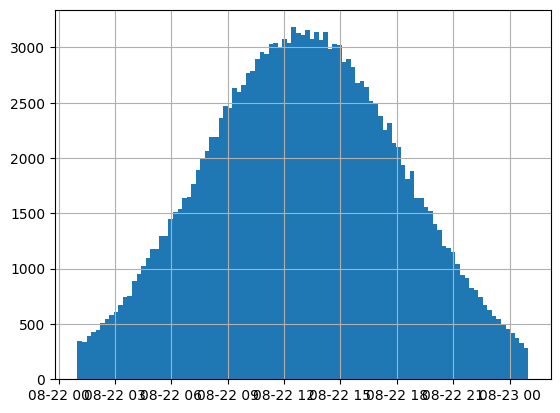

In [ ]:
from sklearn.linear_model import LinearRegression


def find_time_outliers(df, n=4):
    model = LinearRegression()
    model.fit(X=np.expand_dims(df['tx_datetime'].values.astype(np.int64), axis=0).T // 10 ** 9, y=df['tx_time_seconds'])
    residuals = model.predict(np.expand_dims(df['tx_datetime'].values.astype(np.int64), axis=0).T // 10 ** 9) - df['tx_time_seconds']
    border = n * residuals.std()
    return residuals.abs() < border if border > 0 else np.ones(residuals.shape[0], dtype=bool)

df[find_time_outliers(df)]['tx_datetime'].hist(bins=99)

# Соединяем воедино все методы в одну функцию

In [ ]:
def clear_data(df):
    nrows = df.shape[0]
    df = df[df.notna().all(axis=1)] # Удаляем пропуски
    print(f'Удалено {nrows - df.shape[0]} строк с отсутствующими данными')
    nrows = df.shape[0]
    df.loc[:, 'tx_datetime'] = fix_date(df['tx_datetime'], verbose=True) # Фиксим даты
    df = df[df['tx_datetime'] != np.datetime64('NaT')]
    print(f'Удалено {nrows - df.shape[0]} строк с некорректной датой')
    nrows = df.shape[0]
    df = df[df['tx_amount'] < tx_amount_95]
    print(f'Удалено {nrows - df.shape[0]} строк с экстремально высоким tx_amount')
    nrows = df.shape[0]
    df = df[find_time_outliers(df)]
    print(f'Удалено {nrows - df.shape[0]} строк tx_time_seconds с выбросами')
    return df

========= fraud-data/2019-08-22.txt ========
Удалено 1 строк с отсутствующими данными
Обнаружено 0 ошибок в дате, исправлено 0
Удалено 0 строк с некорректной датой
Удалено 9196 строк с экстремально высоким tx_amount
Удалено 0 строк tx_time_seconds с выбросами
========= fraud-data/2019-09-21.txt ========
Удалено 3 строк с отсутствующими данными
Обнаружено 0 ошибок в дате, исправлено 0
Удалено 0 строк с некорректной датой
Удалено 8311 строк с экстремально высоким tx_amount
Удалено 0 строк tx_time_seconds с выбросами
========= fraud-data/2019-10-21.txt ========
Удалено 1 строк с отсутствующими данными
Обнаружено 0 ошибок в дате, исправлено 0
Удалено 0 строк с некорректной датой
Удалено 8238 строк с экстремально высоким tx_amount
Удалено 0 строк tx_time_seconds с выбросами
========= fraud-data/2019-11-20.txt ========
Удалено 5 строк с отсутствующими данными
Обнаружено 0 ошибок в дате, исправлено 0
Удалено 0 строк с некорректной датой
Удалено 8201 строк с экстремально высоким tx_amount
Удал

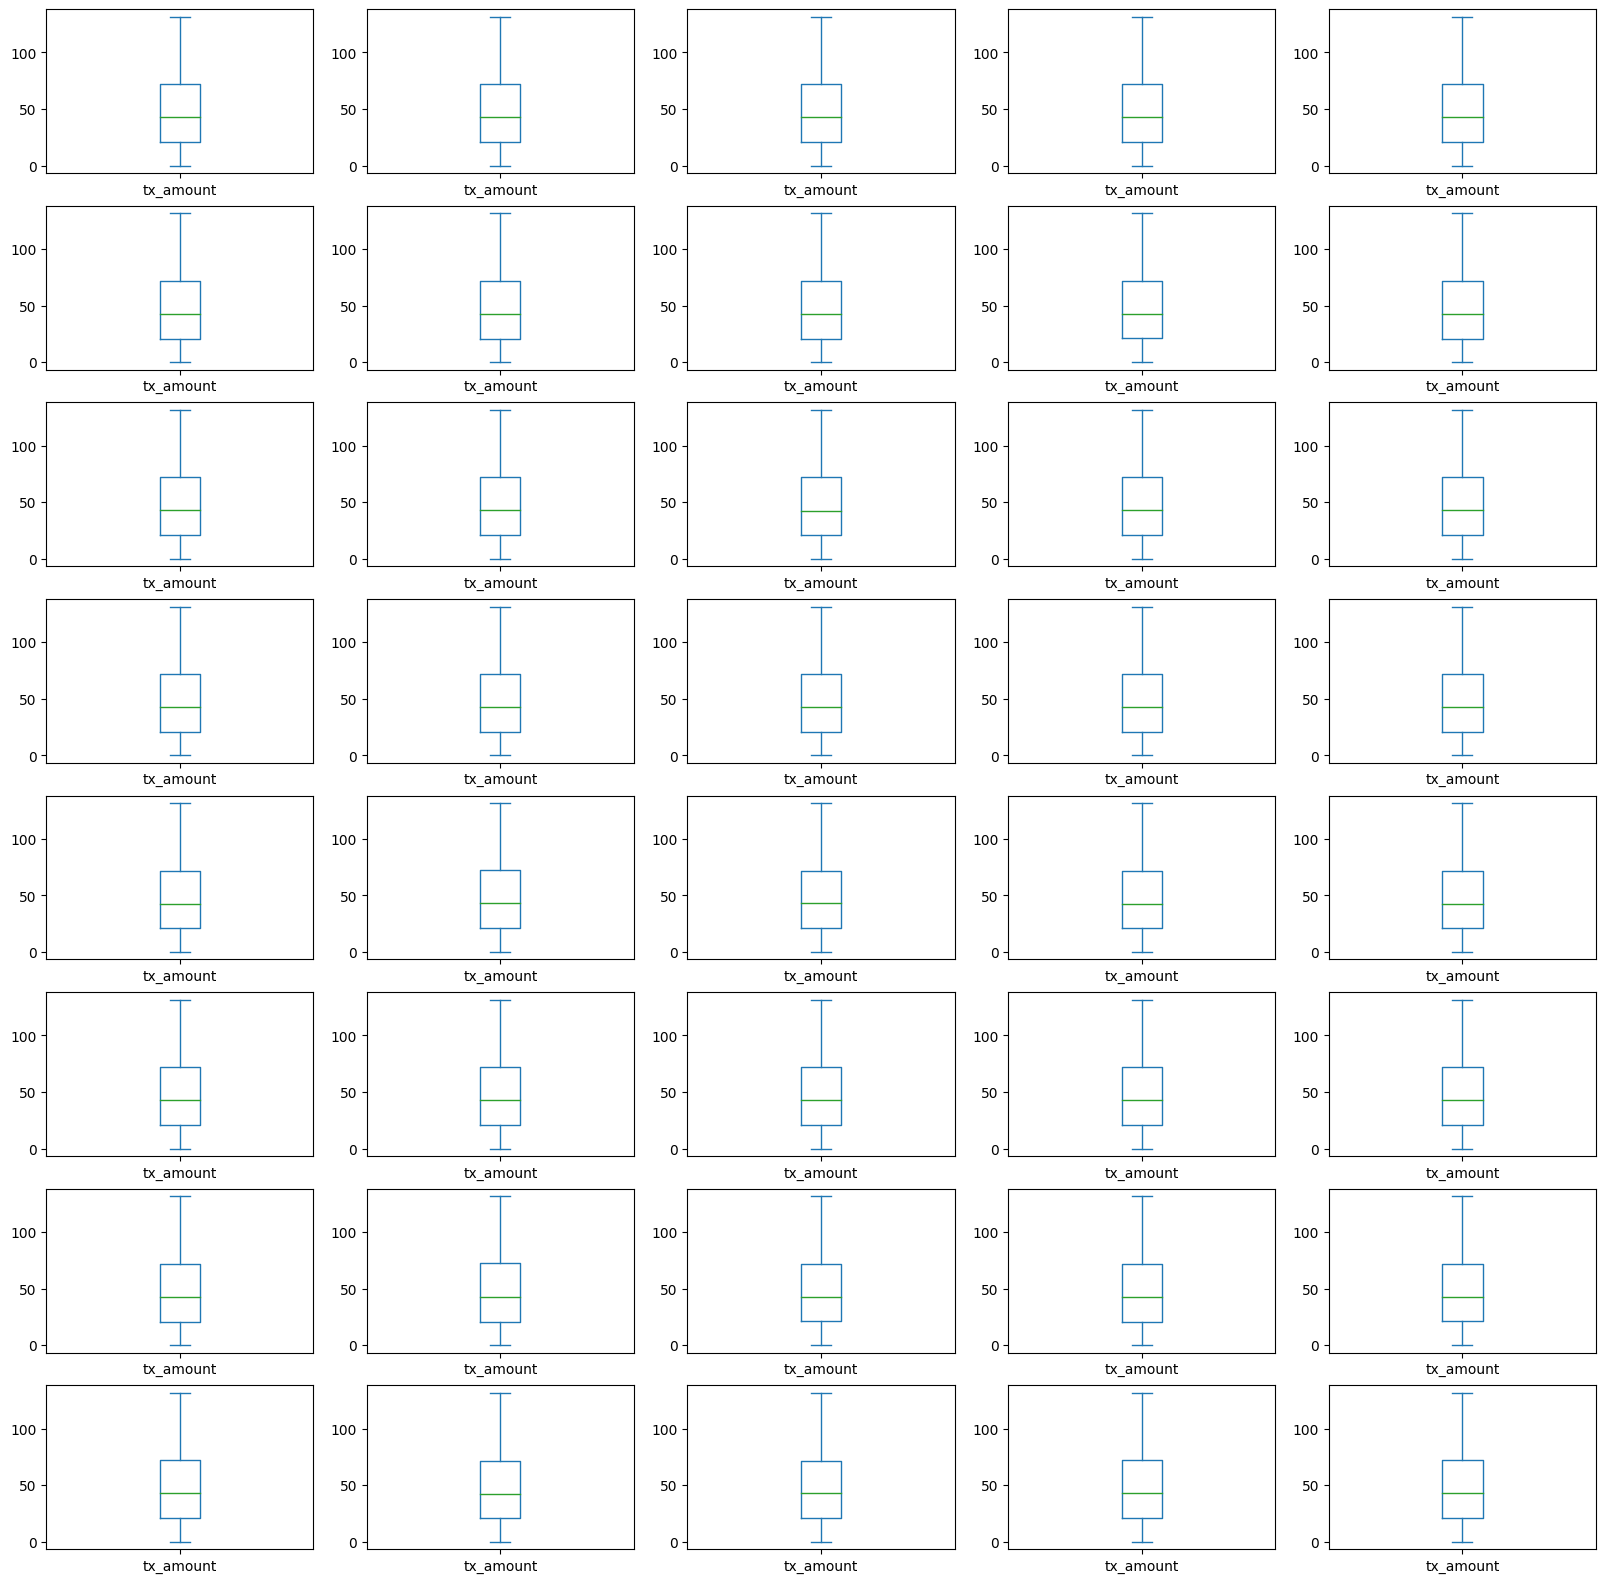

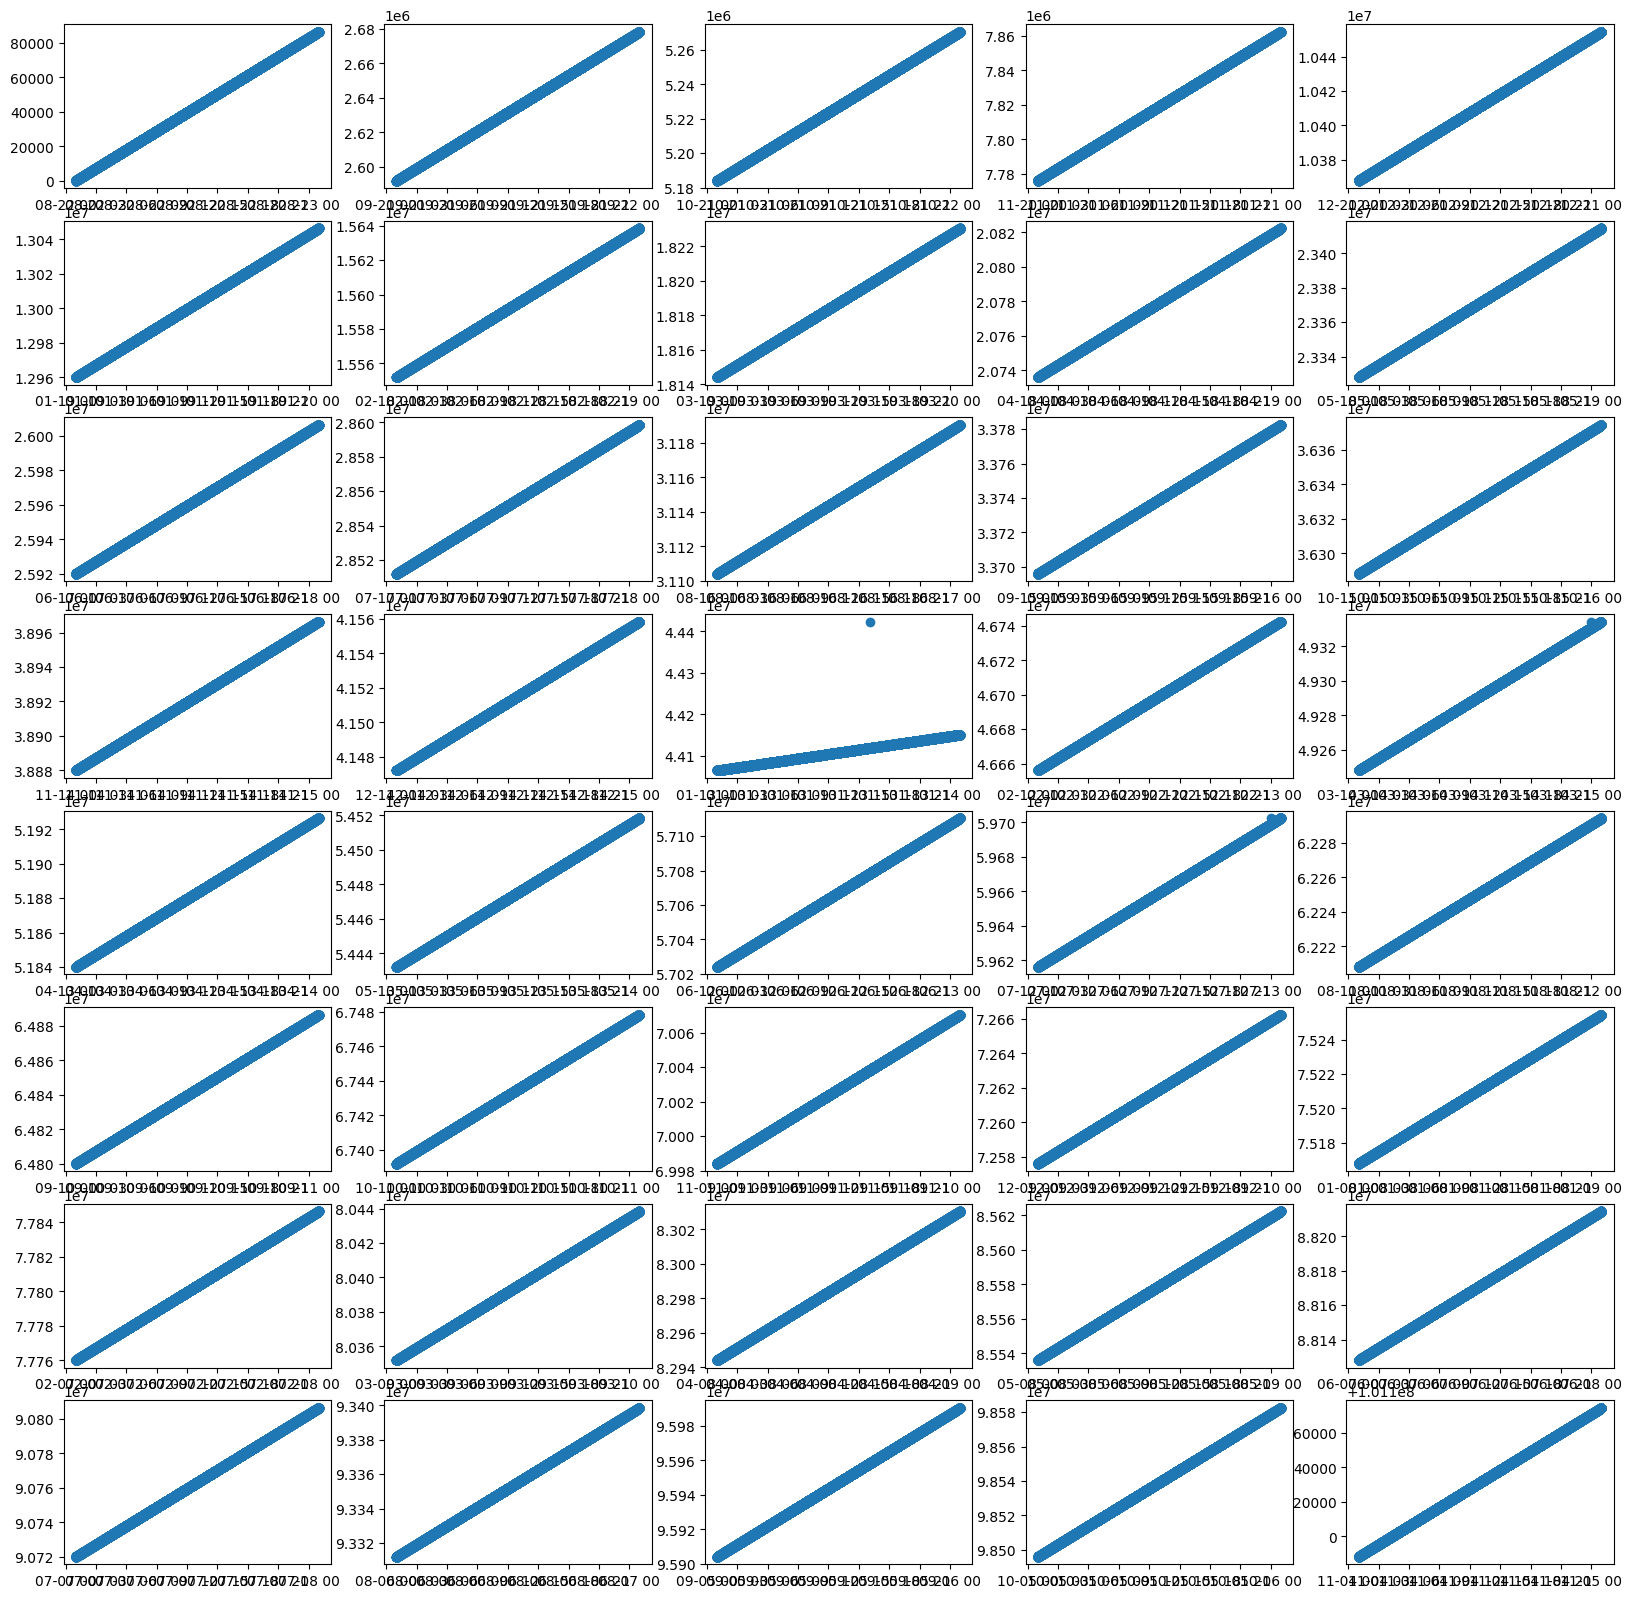

In [ ]:
tx_amount, tx_amount_ax = plt.subplots(nrows=8, ncols=5, figsize=(20,20))
tx_time_seconds, tx_time_seconds_ax = plt.subplots(nrows=8, ncols=5, figsize=(20,20))
n_row, n_col = 0, 0

for data in data_bucket.objects.all():
    print(f'========= {data.key} ========')
    df = read_csv(data, n_bytes = 10000000)
    df = clear_data(df)
    df = df[['tx_datetime', 'tx_amount', 'tx_time_seconds']]
    df.sort_values('tx_datetime', inplace=True)
    df['tx_amount'].plot.box(ax=tx_amount_ax[n_row, n_col])
    tx_time_seconds_ax[n_row, n_col].scatter(df['tx_datetime'], df['tx_time_seconds'])
    n_row = n_row if n_col + 1 < 5 else n_row + 1
    n_col = n_col + 1 if n_col < 4 else 0